##  Fraud & AML Intelligence Analysis – Upesi Digital Bank

**Student Name:** Claudine Linda Wa Nciko  
**Student Number:** 169375  
**Case Study: Question 4 (55 Marks)**  
**Tool: Network-Based Anomaly Detection using Python & NetworkX**

---

###  Introduction

Upesi Digital Bank, a leading fintech platform operating across East Africa, processes thousands of transactions daily. A recent risk audit highlighted patterns of concern not visible through traditional risk scoring. The bank's compliance team suspects the presence of:

- **Sleeper accounts**: Dormant for long periods, then suddenly active.
- **Circular transactions**: Fund flows that loop through multiple accounts.
- **Collusion rings**: Tight clusters of accounts coordinating activity.
- **Invisible intermediaries**: Accounts quietly moving high volumes between clusters.

This case study uses **graph-based techniques** to model the transaction network as a **directed graph**, where:
- **Nodes** represent customers
- **Edges** represent financial transactions between them

By computing structural, temporal, and flow-based metrics, this notebook detects and flags **suspicious accounts** based on behavioral deviations from the network norm. Insights are supported by **visual evidence**, and results are summarized for action by the bank’s fraud investigation unit.


# Setup and Library Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


# Set plot style and display settings
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configure pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')


# Load Datasets and Initial Preview

In [2]:
# Define file paths
customer_file_path = '/content/Question4customers.csv'
transaction_file_path = '/content/Question4transactions.csv'

# Read the datasets into pandas DataFrames
customers_data = pd.read_csv(customer_file_path)
transactions_data = pd.read_csv(transaction_file_path)


In [3]:
print("Sample Customer Data:"),customers_data.head()

Sample Customer Data:


(None,
   customer_id        name risk_segment nationality  is_business
 0    CUST0000  Customer_0          low     Rwandan            0
 1    CUST0001  Customer_1         high     Rwandan            0
 2    CUST0002  Customer_2       medium   Tanzanian            0
 3    CUST0003  Customer_3          low      Kenyan            0
 4    CUST0004  Customer_4          low     Rwandan            0)

In [4]:
print("\nSample Transaction Data:"), transactions_data.head()


Sample Transaction Data:


(None,
   sender_id receiver_id  amount   timestamp
 0  CUST0163    CUST0028  598.93  2023-01-13
 1  CUST0189    CUST0070  384.04  2023-05-06
 2  CUST0057    CUST0035  185.19  2023-02-22
 3  CUST0173    CUST0189  840.45  2023-10-07
 4  CUST0022    CUST0151  577.16  2023-08-05)

# Data Summary and Info

In [5]:
# Data summary for customers
print("\nCustomer Dataset Information:")
customers_data_info = customers_data.describe(include='all')
customers_data_info


Customer Dataset Information:


,customer_id,name,risk_segment,nationality,is_business
count,200,200,200,200,200.00
unique,200,200,3,4,NaN
top,CUST0000,Customer_0,low,Rwandan,NaN
freq,1,1,122,58,NaN
mean,NaN,NaN,NaN,NaN,0.17
std,NaN,NaN,NaN,NaN,0.38
min,NaN,NaN,NaN,NaN,0.00
25%,NaN,NaN,NaN,NaN,0.00
50%,NaN,NaN,NaN,NaN,0.00
75%,NaN,NaN,NaN,NaN,0.00


In [6]:
# Data summary for transactions
print("\nTransaction Dataset Information:")
transactions_data_info = transactions_data.describe(include='all')
transactions_data_info


Transaction Dataset Information:


,sender_id,receiver_id,amount,timestamp
count,2000,2000,2000.00,2000
unique,200,200,NaN,365
top,CUST0115,CUST0141,NaN,2023-08-21
freq,17,19,NaN,12
mean,NaN,NaN,499.52,NaN
std,NaN,NaN,502.85,NaN
min,NaN,NaN,0.78,NaN
25%,NaN,NaN,139.46,NaN
50%,NaN,NaN,349.65,NaN
75%,NaN,NaN,685.55,NaN


# Data Preprocessing

Check for Missing Values

In [7]:
# Check for missing values customer datasets
print("Missing Data in Customer Dataset:")
missing_customers = customers_data.isnull().sum()
missing_customers

Missing Data in Customer Dataset:


,0
customer_id,0
name,0
risk_segment,0
nationality,0
is_business,0


In [8]:
# Check for missing values in transaction datasets
print("\nMissing Data in Transaction Dataset:")
missing_transactions = transactions_data.isnull().sum()
missing_transactions



Missing Data in Transaction Dataset:


,0
sender_id,0
receiver_id,0
amount,0
timestamp,0


Convert and Sort Data

In [9]:
# Convert the 'timestamp' column in transactions to datetime
transactions_data['timestamp'] = pd.to_datetime(transactions_data['timestamp'])

# Sort transactions based on the timestamp to maintain correct order
transactions_data.sort_values(by='timestamp', inplace=True)


Ensure Consistent Data Types

In [10]:
# Ensure all customer and transaction IDs are of type string for consistency
customers_data['customer_id'] = customers_data['customer_id'].astype(str)
transactions_data['sender_id'] = transactions_data['sender_id'].astype(str)
transactions_data['receiver_id'] = transactions_data['receiver_id'].astype(str)


Identify Missing Participants

In [11]:
# Identify any missing participants in the transactions
transaction_senders = set(transactions_data['sender_id'])
transaction_receivers = set(transactions_data['receiver_id'])
all_customers = set(customers_data['customer_id'])

# Calculate missing senders and receivers
missing_senders = transaction_senders - all_customers
missing_receivers = transaction_receivers - all_customers

print(f"\nMissing senders in the customer dataset: {len(missing_senders)}")
print(f"Missing receivers in the customer dataset: {len(missing_receivers)}")



Missing senders in the customer dataset: 0
Missing receivers in the customer dataset: 0


Handle Missing Customers

In [12]:
# If there are missing customers, create placeholder records for them
if missing_senders or missing_receivers:
    missing_ids = list(transaction_senders.union(transaction_receivers) - all_customers)

    # Create placeholder customers for missing IDs
    placeholder_entries = pd.DataFrame({
        'customer_id': missing_ids,
        'name': ['Unknown' for _ in range(len(missing_ids))],
        'risk_segment': ['unknown' for _ in range(len(missing_ids))],
        'nationality': ['unknown' for _ in range(len(missing_ids))],
        'is_business': [np.nan for _ in range(len(missing_ids))]
    })

    # Append placeholder customers to the original customer dataset
    customers_data = pd.concat([customers_data, placeholder_entries], ignore_index=True)


# Transaction Network Construction

Initialize Network Graph

Corrected Block: Feature Engineering – Centrality Measures

In [13]:
import networkx as nx

# Ensure IDs are strings
customers_data['customer_id'] = customers_data['customer_id'].astype(str)
transactions_data['sender_id'] = transactions_data['sender_id'].astype(str)
transactions_data['receiver_id'] = transactions_data['receiver_id'].astype(str)

# Initialize directed graph
network_graph = nx.DiGraph()

# Add customer nodes with metadata
for _, row in customers_data.iterrows():
    network_graph.add_node(
        row['customer_id'],
        name=row['name'],
        risk_segment=row['risk_segment'],
        nationality=row['nationality'],
        is_business=row['is_business']
    )

# Add edges representing transactions
for _, txn in transactions_data.iterrows():
    sender = txn['sender_id']
    receiver = txn['receiver_id']

    if network_graph.has_edge(sender, receiver):
        # Update existing edge
        network_graph[sender][receiver]['weight'] += txn['amount']
        network_graph[sender][receiver]['transactions'].append({
            'amount': txn['amount'],
            'timestamp': txn['timestamp']
        })
        network_graph[sender][receiver]['transaction_count'] += 1
    else:
        # Create new edge
        network_graph.add_edge(
            sender,
            receiver,
            weight=txn['amount'],
            transactions=[{
                'amount': txn['amount'],
                'timestamp': txn['timestamp']
            }],
            transaction_count=1
        )

# Basic graph statistics
print(f"Total number of customers (nodes): {network_graph.number_of_nodes()}")
print(f"Total number of transaction relationships (edges): {network_graph.number_of_edges()}")
print(f"Is the graph directed?: {nx.is_directed(network_graph)}")
print(f"Is the graph weakly connected?: {nx.is_weakly_connected(network_graph)}")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(network_graph)}")


Total number of customers (nodes): 200
Total number of transaction relationships (edges): 1953
Is the graph directed?: True
Is the graph weakly connected?: True
Number of weakly connected components: 1


#  Feature Engineering – Network Metrics


In [14]:
print("Computing network metrics...")

# In-degree & Out-degree (number of incoming/outgoing connections)
in_degree_dict = dict(network_graph.in_degree())
out_degree_dict = dict(network_graph.out_degree())

# In-weight & Out-weight (total amount received/sent)
in_weight_dict = {
    node: sum([network_graph[u][v]['weight'] for u, v in network_graph.in_edges(node)])
    for node in network_graph.nodes()
}
out_weight_dict = {
    node: sum([network_graph[u][v]['weight'] for u, v in network_graph.out_edges(node)])
    for node in network_graph.nodes()
}

# Net flow (money sent - money received)
net_flow_dict = {
    node: out_weight_dict[node] - in_weight_dict[node]
    for node in network_graph.nodes()
}

# Betweenness centrality (path-based importance)
betweenness_dict = nx.betweenness_centrality(network_graph, k=min(500, network_graph.number_of_nodes()))

# PageRank (recursive importance based on connections)
pagerank_dict = nx.pagerank(network_graph)

# Eigenvector centrality
try:
    eigenvector_dict = nx.eigenvector_centrality(network_graph, max_iter=1000)
except:
    print("Eigenvector centrality failed to converge. Using approximation.")
    eigenvector_dict = nx.eigenvector_centrality_numpy(network_graph)

# HITS scores (hub and authority)
hub_dict, authority_dict = nx.hits(network_graph, max_iter=1000)

# Closeness centrality
try:
    closeness_dict = nx.closeness_centrality(network_graph)
except:
    print("Disconnected graph – using component-wise closeness centrality.")
    closeness_dict = {}
    for component in nx.weakly_connected_components(network_graph):
        subgraph = network_graph.subgraph(component)
        closeness_dict.update(nx.closeness_centrality(subgraph))


Computing network metrics...


Build Centrality DataFrame + Derived Metrics

In [15]:
# Create DataFrame with node-level features
metrics_df = pd.DataFrame({
    'customer_id': list(network_graph.nodes()),
    'in_degree': [in_degree_dict[node] for node in network_graph.nodes()],
    'out_degree': [out_degree_dict[node] for node in network_graph.nodes()],
    'total_degree': [in_degree_dict[node] + out_degree_dict[node] for node in network_graph.nodes()],
    'in_weight': [in_weight_dict[node] for node in network_graph.nodes()],
    'out_weight': [out_weight_dict[node] for node in network_graph.nodes()],
    'total_volume': [in_weight_dict[node] + out_weight_dict[node] for node in network_graph.nodes()],
    'net_flow': [net_flow_dict[node] for node in network_graph.nodes()],
    'betweenness_centrality': [betweenness_dict[node] for node in network_graph.nodes()],
    'pagerank': [pagerank_dict[node] for node in network_graph.nodes()],
    'eigenvector_centrality': [eigenvector_dict[node] for node in network_graph.nodes()],
    'hub_score': [hub_dict[node] for node in network_graph.nodes()],
    'authority_score': [authority_dict[node] for node in network_graph.nodes()],
    'closeness_centrality': [closeness_dict[node] for node in network_graph.nodes()]
})

# Merge with customer metadata (name, nationality, etc.)
metrics_df = metrics_df.merge(customers_data, on='customer_id', how='left')

# Derived features
metrics_df['turnover_ratio'] = metrics_df.apply(
    lambda row: min(row['in_weight'], row['out_weight']) / max(row['in_weight'], row['out_weight'])
    if max(row['in_weight'], row['out_weight']) > 0 else 0,
    axis=1
)

metrics_df['transaction_efficiency'] = metrics_df['total_volume'] / (metrics_df['total_degree'] + 1)

# Preview results
print("Network metrics computed. Previewing top rows:")
metrics_df.head()


Network metrics computed. Previewing top rows:


,customer_id,in_degree,out_degree,total_degree,in_weight,out_weight,total_volume,net_flow,betweenness_centrality,pagerank,eigenvector_centrality,hub_score,authority_score,closeness_centrality,name,risk_segment,nationality,is_business,turnover_ratio,transaction_efficiency
0,CUST0000,9,6,15,5030.91,3353.06,8383.97,-1677.85,0.00,0.00,0.07,0.00,0.01,0.39,Customer_0,low,Rwandan,0,0.67,524.00
1,CUST0001,7,12,19,2825.35,7909.79,10735.14,5084.44,0.01,0.00,0.04,0.01,0.00,0.37,Customer_1,high,Rwandan,0,0.36,536.76
2,CUST0002,10,15,25,4707.10,11865.75,16572.85,7158.65,0.01,0.01,0.07,0.02,0.00,0.39,Customer_2,medium,Tanzanian,0,0.40,637.42
3,CUST0003,6,10,16,1704.09,6708.76,8412.85,5004.67,0.01,0.00,0.04,0.01,0.00,0.36,Customer_3,low,Kenyan,0,0.25,494.87
4,CUST0004,6,6,12,2965.14,2364.38,5329.52,-600.76,0.00,0.00,0.05,0.00,0.00,0.37,Customer_4,low,Rwandan,0,0.80,409.96


# Temporal Features – Sleeper Account & Activity Burst Detection


In [16]:
from collections import defaultdict
# Prepare storage for each customer's temporal activity
activity_summary = {}

# Convert timestamp column to datetime
transactions_data['timestamp'] = pd.to_datetime(transactions_data['timestamp'])

# Establish overall observed period
full_range_days = (transactions_data['timestamp'].max() - transactions_data['timestamp'].min()).days + 1

# Loop through each customer to calculate temporal stats
for cust_id in metrics_df['customer_id']:
    sent = transactions_data[transactions_data['sender_id'] == cust_id]
    received = transactions_data[transactions_data['receiver_id'] == cust_id]
    full_txns = pd.concat([sent, received]).sort_values(by='timestamp')

    if not full_txns.empty:
        first_seen = full_txns['timestamp'].min()
        last_seen = full_txns['timestamp'].max()
        span_days = (last_seen - first_seen).days + 1
        txn_count = full_txns.shape[0]

        timestamps = full_txns['timestamp'].tolist()
        daily_rate = txn_count / span_days if span_days > 0 else 0
        density_ratio = span_days / full_range_days if full_range_days > 0 else 0

        # Calculate burstiness (coefficient of variation of time gaps)
        if len(timestamps) > 1:
            numeric_times = [ts.timestamp() for ts in timestamps]
            gaps = np.diff(sorted(numeric_times))
            burst_score = np.std(gaps) / np.mean(gaps) if np.mean(gaps) > 0 else 0
        else:
            burst_score = 0

        activity_summary[cust_id] = {
            'first_txn': first_seen,
            'last_txn': last_seen,
            'active_days': span_days,
            'txn_count': txn_count,
            'txns_per_day': daily_rate,
            'active_period_pct': density_ratio,
            'burstiness': burst_score
        }
    else:
        activity_summary[cust_id] = {
            'first_txn': pd.NaT,
            'last_txn': pd.NaT,
            'active_days': 0,
            'txn_count': 0,
            'txns_per_day': 0,
            'active_period_pct': 0,
            'burstiness': 0
        }

# Integrate temporal features into metrics_df
metrics_df['first_txn_date'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['first_txn'])
metrics_df['last_txn_date'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['last_txn'])
metrics_df['active_days'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['active_days'])
metrics_df['total_txns'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['txn_count'])
metrics_df['txns_per_day'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['txns_per_day'])
metrics_df['activity_period_pct'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['active_period_pct'])
metrics_df['burstiness'] = metrics_df['customer_id'].map(lambda x: activity_summary[x]['burstiness'])

# Sleeper account score: burstiness × transaction frequency / activity coverage
metrics_df['sleeper_score'] = (
    metrics_df['burstiness'] * metrics_df['txns_per_day'] / (metrics_df['activity_period_pct'] + 0.01)
)

# Display relevant columns
print("Added temporal activity features:")
metrics_df[['customer_id', 'active_days', 'total_txns', 'txns_per_day', 'activity_period_pct', 'burstiness', 'sleeper_score']].head()


Added temporal activity features:


,customer_id,active_days,total_txns,txns_per_day,activity_period_pct,burstiness,sleeper_score
0,CUST0000,354,16,0.05,0.97,1.30,0.06
1,CUST0001,354,20,0.06,0.97,0.77,0.04
2,CUST0002,360,25,0.07,0.98,0.87,0.06
3,CUST0003,340,16,0.05,0.93,1.03,0.05
4,CUST0004,313,13,0.04,0.86,0.99,0.05


#  Circular Transaction Detection (Optimized + Capped at 1500)

In [17]:
import random

def detect_circular_flows(graph, max_length=5, max_cycles=1500):
    """
    Efficient cycle detection by constraining depth and node sampling.

    Parameters:
        graph (networkx.DiGraph): The transaction network
        max_length (int): Maximum allowed cycle size
        max_cycles (int): Limit on total cycles to extract

    Returns:
        list: Detected cycles (as node lists)
    """
    found_cycles = []
    cycles_so_far = 0

    # Focus only on nodes that can both send and receive
    candidate_nodes = [
        node for node in graph.nodes()
        if graph.in_degree(node) > 0 and graph.out_degree(node) > 0
    ]

    # Randomly reduce search space if too large
    if len(candidate_nodes) > 200:
        random.seed(42)
        candidate_nodes = random.sample(candidate_nodes, 200)

    # DFS-based cycle detection
    for origin in candidate_nodes:
        path_stack = [(origin, [origin])]
        while path_stack and cycles_so_far < max_cycles:
            current_node, path = path_stack.pop()
            for neighbor in graph.successors(current_node):
                if neighbor == origin and len(path) > 1:
                    found_cycles.append(path.copy())
                    cycles_so_far += 1
                    if cycles_so_far >= max_cycles:
                        break
                elif neighbor not in path and len(path) < max_length:
                    path_stack.append((neighbor, path + [neighbor]))

    print(f"Found {len(found_cycles)} cycles with optimized approach (limited to {max_cycles})")
    return found_cycles

# Run the optimized loop finder
print("\nDetecting circular transaction patterns...")
loop_cycles = detect_circular_flows(network_graph, max_length=5, max_cycles=1500)



Detecting circular transaction patterns...
Found 1500 cycles with optimized approach (limited to 1500)


Add Cycle Metrics to Node Table

In [18]:
# Prepare empty cycle participation records
node_loops = {node: [] for node in network_graph.nodes()}
loop_counts = {node: 0 for node in network_graph.nodes()}

# Count participation in cycles
for c in loop_cycles:
    for n in c:
        node_loops[n].append(c)
        loop_counts[n] += 1

# Add to metrics_df
metrics_df['cycle_count'] = metrics_df['customer_id'].map(lambda x: loop_counts.get(x, 0))
metrics_df['cycle_participation'] = metrics_df['cycle_count'] / (len(loop_cycles) + 1)  # +1 avoids zero div

# Compute average-adjusted cycle weight
def importance_from_loops(node_id):
    loops = node_loops.get(node_id, [])
    if loops:
        avg_len = np.mean([len(c) for c in loops])
        return len(loops) / avg_len
    return 0

metrics_df['cycle_importance'] = metrics_df['customer_id'].map(importance_from_loops)

# Show output
print("\nCycle-based network metrics:")
metrics_df[['customer_id', 'cycle_count', 'cycle_participation', 'cycle_importance']].head()



Cycle-based network metrics:


,customer_id,cycle_count,cycle_participation,cycle_importance
0,CUST0000,327,0.22,66.83
1,CUST0001,396,0.26,80.92
2,CUST0002,767,0.51,156.58
3,CUST0003,122,0.08,24.81
4,CUST0004,4,0.00,0.80


 # Community Detection & Collusion Ring Analysis

Community Detection & Collusion Ring Metrics (Louvain + Bridge Score)

In [19]:
print("\nDetecting communities using Louvain method...")

# Convert the directed graph to undirected
undirected_graph = network_graph.to_undirected()

# Try to load Louvain method from community-louvain package
try:
    import community.community_louvain as community_louvain
    partition = community_louvain.best_partition(undirected_graph)
    method_used = "Louvain"
except ImportError:
    try:
        from community import community_louvain
        partition = community_louvain.best_partition(undirected_graph)
        method_used = "Louvain"
    except ImportError:
        print("Louvain not installed. Falling back to connected components.")
        partition = {}
        for i, group in enumerate(nx.connected_components(undirected_graph)):
            for node in group:
                partition[node] = i
        method_used = "Connected Components"

# Add community ID to each customer
metrics_df['community_id'] = metrics_df['customer_id'].map(lambda x: partition.get(x, -1))

# Count number of members per community
community_sizes = pd.Series(partition.values()).value_counts().to_dict()
metrics_df['community_size'] = metrics_df['community_id'].map(lambda x: community_sizes.get(x, 0))



Detecting communities using Louvain method...


Bridge Score Calculation (Internal vs External Connections)

In [20]:
# Calculate internal and external links per customer
internal_links = {}
external_links = {}

for cust in network_graph.nodes():
    comm_id = partition[cust]
    in_same, out_diff = 0, 0

    # Outgoing edges
    for target in network_graph.successors(cust):
        if partition.get(target) == comm_id:
            in_same += 1
        else:
            out_diff += 1

    # Incoming edges
    for source in network_graph.predecessors(cust):
        if partition.get(source) == comm_id:
            in_same += 1
        else:
            out_diff += 1

    internal_links[cust] = in_same
    external_links[cust] = out_diff

# Add bridge metrics to DataFrame
metrics_df['internal_connections'] = metrics_df['customer_id'].map(lambda x: internal_links.get(x, 0))
metrics_df['external_connections'] = metrics_df['customer_id'].map(lambda x: external_links.get(x, 0))

# Bridge score = share of connections that go outside the community
metrics_df['bridge_score'] = metrics_df.apply(
    lambda row: row['external_connections'] / (row['internal_connections'] + row['external_connections'] + 0.01),
    axis=1
)

print(f"\nCommunity detection completed using: {method_used}")
metrics_df[['customer_id', 'community_id', 'community_size', 'internal_connections', 'external_connections', 'bridge_score']].head()



Community detection completed using: Louvain


,customer_id,community_id,community_size,internal_connections,external_connections,bridge_score
0,CUST0000,6,22,6,9,0.60
1,CUST0001,1,25,4,15,0.79
2,CUST0002,9,33,10,15,0.60
3,CUST0003,0,17,6,10,0.62
4,CUST0004,4,18,4,8,0.67


In [21]:
# Normalize metrics for scoring (min-max scaling)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale selected features
to_scale = metrics_df[['betweenness_centrality', 'bridge_score', 'cycle_participation']]
scaled = scaler.fit_transform(to_scale)

# Create normalized columns
metrics_df['scaled_betweenness'] = scaled[:, 0]
metrics_df['scaled_bridge'] = scaled[:, 1]
metrics_df['scaled_cycle_participation'] = scaled[:, 2]

# Composite intermediary score
metrics_df['intermediary_score'] = (
    0.5 * metrics_df['scaled_betweenness'] +
    0.3 * metrics_df['scaled_bridge'] +
    0.2 * metrics_df['scaled_cycle_participation']
)

# Sort and inspect top candidates
print("\nTop suspected intermediary accounts:")
metrics_df[['customer_id', 'intermediary_score', 'betweenness_centrality', 'bridge_score', 'total_txns']].sort_values(
    by='intermediary_score', ascending=False
).head(10)



Top suspected intermediary accounts:


,customer_id,intermediary_score,betweenness_centrality,bridge_score,total_txns
84,CUST0084,0.69,0.02,0.90,29
80,CUST0080,0.64,0.02,0.86,28
165,CUST0165,0.62,0.02,0.62,30
137,CUST0137,0.61,0.02,0.86,29
144,CUST0144,0.60,0.02,0.82,31
163,CUST0163,0.58,0.01,0.88,25
2,CUST0002,0.58,0.01,0.60,25
141,CUST0141,0.57,0.02,0.76,29
179,CUST0179,0.57,0.01,0.80,25
189,CUST0189,0.56,0.01,0.85,26


Flow-Based Intermediary Behavior Analysis

In [22]:
print("\nAnalyzing temporal intermediary behavior...")

flow_signals = {}

for node in network_graph.nodes():
    # Skip isolated nodes
    if network_graph.in_degree(node) == 0 or network_graph.out_degree(node) == 0:
        flow_signals[node] = {
            'avg_time_gap_hours': 0,
            'flow_volume_ratio': 0,
            'quick_pass_count': 0,
            'flow_intermediary_score': 0
        }
        continue

    # Collect incoming and outgoing transactions
    incoming = list(network_graph.in_edges(node, data=True))
    outgoing = list(network_graph.out_edges(node, data=True))

    time_diffs = []

    for u, _, in_edge in incoming:
        in_txns = in_edge['transactions']
        for _, v, out_edge in outgoing:
            out_txns = out_edge['transactions']

            for in_txn in in_txns:
                for out_txn in out_txns:
                    in_time = pd.to_datetime(in_txn['timestamp'])
                    out_time = pd.to_datetime(out_txn['timestamp'])

                    # Only count if funds sent after received
                    if out_time > in_time:
                        delta_hours = (out_time - in_time).total_seconds() / 3600
                        time_diffs.append(delta_hours)

    # Compute flow volume ratio
    in_amount = sum(edge[2]['weight'] for edge in incoming)
    out_amount = sum(edge[2]['weight'] for edge in outgoing)
    volume_ratio = min(in_amount, out_amount) / max(in_amount, out_amount) if max(in_amount, out_amount) > 0 else 0

    # Count of pass-throughs under 24 hours
    quick_count = sum(1 for gap in time_diffs if gap <= 24)

    # Intermediary score: favors fast, balanced flows
    flow_score = (quick_count * volume_ratio) / (np.mean(time_diffs) + 1) if time_diffs else 0

    flow_signals[node] = {
        'avg_time_gap_hours': np.mean(time_diffs) if time_diffs else 0,
        'flow_volume_ratio': volume_ratio,
        'quick_pass_count': quick_count,
        'flow_intermediary_score': flow_score
    }



Analyzing temporal intermediary behavior...


Integrate Flow Features into Your Metrics Table

In [23]:
# Add temporal intermediary metrics
metrics_df['avg_time_gap_hours'] = metrics_df['customer_id'].map(lambda x: flow_signals[x]['avg_time_gap_hours'])
metrics_df['flow_volume_ratio'] = metrics_df['customer_id'].map(lambda x: flow_signals[x]['flow_volume_ratio'])
metrics_df['quick_pass_count'] = metrics_df['customer_id'].map(lambda x: flow_signals[x]['quick_pass_count'])
metrics_df['flow_intermediary_score'] = metrics_df['customer_id'].map(lambda x: flow_signals[x]['flow_intermediary_score'])

# View result
print("\nTemporal intermediary signals:")
metrics_df[['customer_id', 'avg_time_gap_hours', 'flow_volume_ratio', 'quick_pass_count', 'flow_intermediary_score']].head()



Temporal intermediary signals:


,customer_id,avg_time_gap_hours,flow_volume_ratio,quick_pass_count,flow_intermediary_score
0,CUST0000,2916.92,0.67,1,0.00
1,CUST0001,2919.16,0.36,0,0.00
2,CUST0002,3428.90,0.40,0,0.00
3,CUST0003,3243.00,0.25,0,0.00
4,CUST0004,888.00,0.80,0,0.00


View Top Flow-Based Intermediaries

In [24]:
print("\nTop suspected flow intermediaries (based on timing and volume):")
metrics_df[['customer_id', 'avg_time_gap_hours', 'flow_volume_ratio', 'quick_pass_count', 'flow_intermediary_score']].sort_values(
    by='flow_intermediary_score', ascending=False
).head(10)



Top suspected flow intermediaries (based on timing and volume):


,customer_id,avg_time_gap_hours,flow_volume_ratio,quick_pass_count,flow_intermediary_score
104,CUST0104,2471.64,0.86,2,0.00
80,CUST0080,3035.46,0.82,2,0.00
162,CUST0162,2949.47,0.70,2,0.00
189,CUST0189,1816.42,0.80,1,0.00
144,CUST0144,3237.38,0.68,2,0.00
35,CUST0035,2251.20,0.82,1,0.00
182,CUST0182,2422.34,0.86,1,0.00
22,CUST0022,2487.82,0.89,1,0.00
27,CUST0027,2636.36,0.90,1,0.00
178,CUST0178,2589.55,0.84,1,0.00


 These accounts pass money, but very slowly, so they're not acting like fast, suspicious intermediaries.

 # Final Anomaly Detection & Customer Flagging Pipeline

In [25]:
# Function to detect outliers using mean + n*std threshold
def flag_outliers(dataframe, feature, n_std=2):
    mean_val = dataframe[feature].mean()
    std_val = dataframe[feature].std()
    threshold = mean_val + n_std * std_val
    return dataframe[feature] > threshold


List of Features to Check

In [26]:
risk_features = [
    'betweenness_centrality', 'pagerank', 'eigenvector_centrality',
    'hub_score', 'authority_score', 'turnover_ratio', 'transaction_efficiency',
    'sleeper_score', 'cycle_importance', 'bridge_score', 'intermediary_score'
]


Generate Flag Columns for Each Feature

In [27]:
for feature in risk_features:
    flag_name = f"{feature}_flag"
    metrics_df[flag_name] = flag_outliers(metrics_df, feature).astype(int)


Compute Total Flags and Filter Suspicious Customers

In [28]:
flag_columns = [f"{f}_flag" for f in risk_features]
metrics_df['total_anomaly_flags'] = metrics_df[flag_columns].sum(axis=1)

# Filter customers with at least 3 anomaly flags
flagged_df = metrics_df[metrics_df['total_anomaly_flags'] >= 3].copy()
print(f"\nIdentified {len(flagged_df)} suspicious accounts with 3+ anomaly indicators.")



Identified 5 suspicious accounts with 3+ anomaly indicators.


Generate Human-Readable Flag Reasons

In [29]:
def explain_flags(row):
    reasons = []
    if row['betweenness_centrality_flag']: reasons.append("Unusual network position")
    if row['pagerank_flag'] or row['eigenvector_centrality_flag']: reasons.append("High network influence")
    if row['turnover_ratio_flag']: reasons.append("Suspicious fund flow ratio")
    if row['sleeper_score_flag']: reasons.append("Sleeper account behavior")
    if row['cycle_importance_flag']: reasons.append("Circular transaction pattern")
    if row['bridge_score_flag']: reasons.append("Bridges between clusters")
    if row['intermediary_score_flag']: reasons.append("Likely pass-through or money mule")
    return " | ".join(reasons)

flagged_df['flag_reason'] = flagged_df.apply(explain_flags, axis=1)


Build Final Report Table and Export

In [30]:
final_flags = flagged_df[[
    'customer_id', 'name', 'risk_segment', 'nationality', 'is_business',
    'total_anomaly_flags', 'flag_reason'
] + flag_columns].copy()

# Preview and save
display(final_flags[['customer_id', 'name', 'risk_segment', 'total_anomaly_flags', 'flag_reason']])
final_flags.to_csv('flagged_customers.csv', index=False)
print("Flagged customers saved to 'flagged_customers.csv'")


,customer_id,name,risk_segment,total_anomaly_flags,flag_reason
11,CUST0011,Customer_11,high,3,High network influence | Sleeper account behavior
84,CUST0084,Customer_84,low,3,Unusual network position | High network influe...
141,CUST0141,Customer_141,low,3,Unusual network position | High network influence
144,CUST0144,Customer_144,low,4,Unusual network position | High network influe...
165,CUST0165,Customer_165,medium,5,Unusual network position | High network influe...


Flagged customers saved to 'flagged_customers.csv'


#  Network Visualization

Visualize Suspicious Cluster



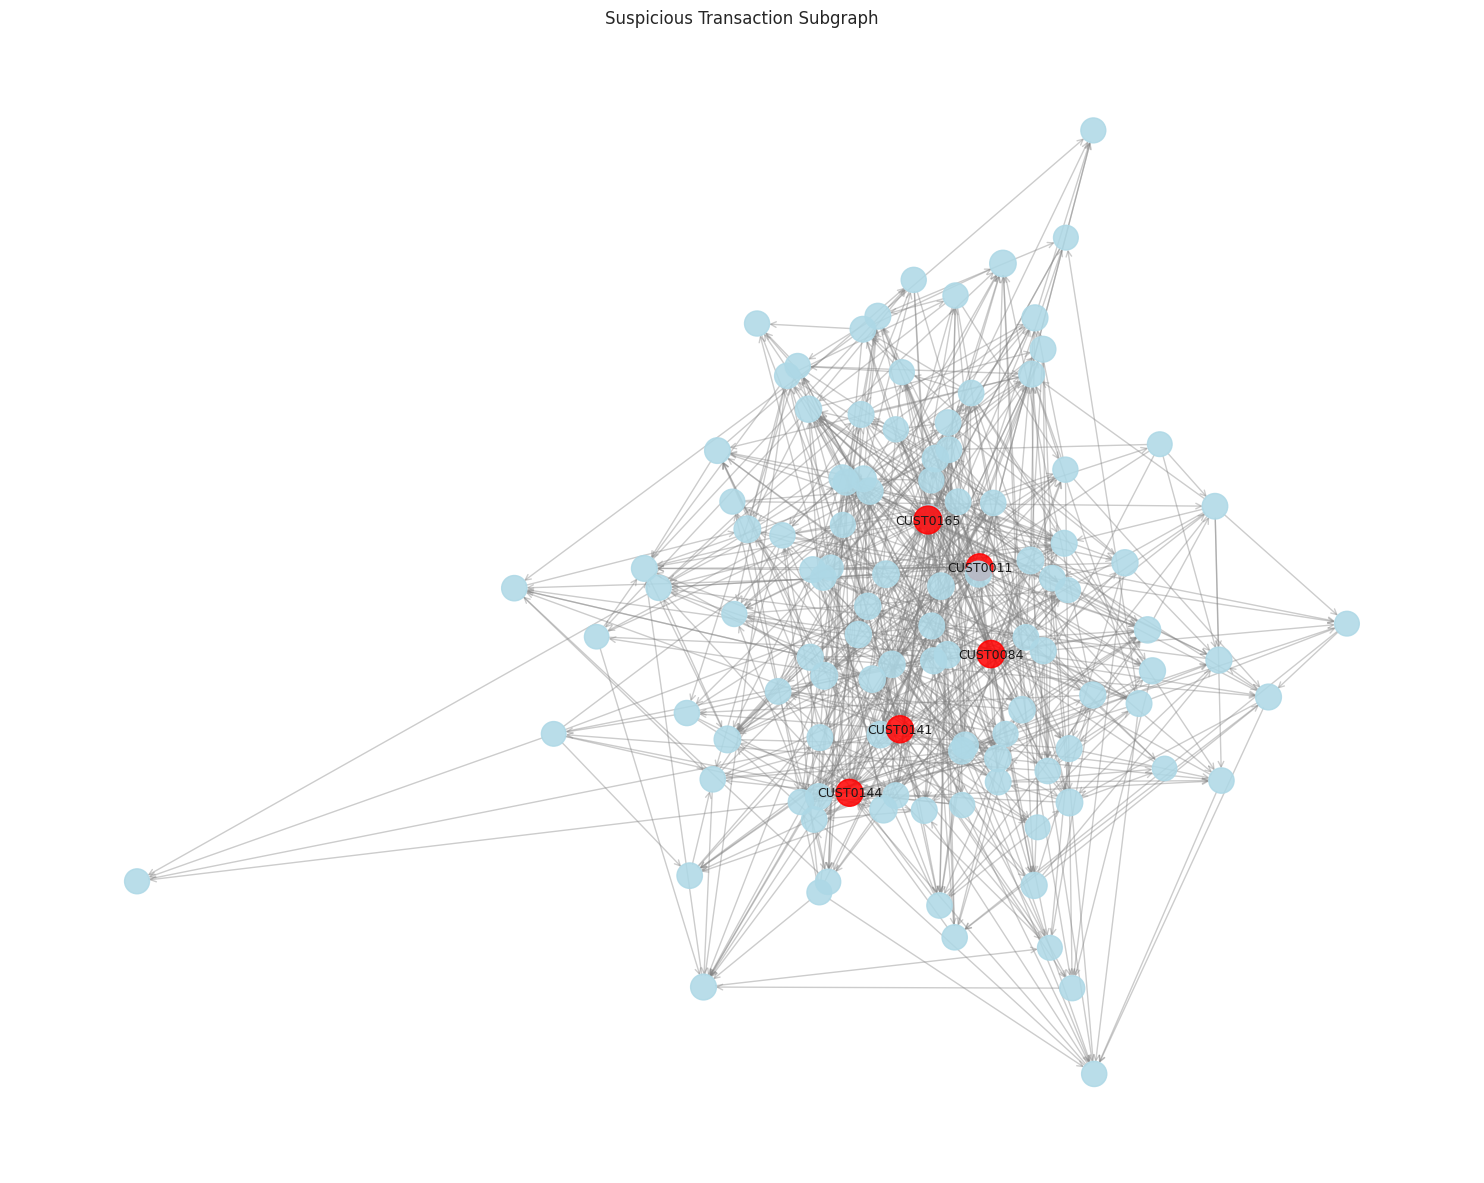

In [32]:
# Get the list of suspicious customer IDs
suspicious_ids = final_flags['customer_id'].tolist()

# Visualize suspicious subgraph

def visualize_suspicious_cluster(G, flagged_ids, metrics, n_neighbors=1, figsize=(15, 12)):
    subgraph_nodes = set(flagged_ids)
    for _ in range(n_neighbors):
        neighbors = set()
        for node in subgraph_nodes:
            if node in G:
                neighbors.update(G.predecessors(node))
                neighbors.update(G.successors(node))
        subgraph_nodes.update(neighbors)

    subgraph = G.subgraph(subgraph_nodes)
    pos = nx.spring_layout(subgraph, seed=42)

    plt.figure(figsize=figsize)

    colors = ['red' if node in flagged_ids else 'lightblue' for node in subgraph.nodes()]
    sizes = [300 + 5000 * metrics.loc[metrics['customer_id'] == node, 'betweenness_centrality'].values[0]
             for node in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos, node_color=colors, node_size=sizes, alpha=0.85)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.4, arrows=True, arrowstyle='->', edge_color='gray')
    labels = {node: node for node in subgraph.nodes() if node in flagged_ids}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=9)

    plt.title("Suspicious Transaction Subgraph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("suspicious_cluster.png", dpi=300)
    plt.show()

visualize_suspicious_cluster(network_graph, suspicious_ids, metrics_df)



The vizual shows:
- A zoomed-in view of suspicious customers (in red) and their 1-hop neighbors (in light blue).
- The structure of interactions between flagged accounts and others.
- Node size shows how central (betweenness) a customer is to fund flows.
- It helps us isolate and inspect suspicious entities, revealing whether they act as hubs, isolated pass-throughs, or well-connected clusters — signs of potential fraud rings.

Visualize circular transaction pattern

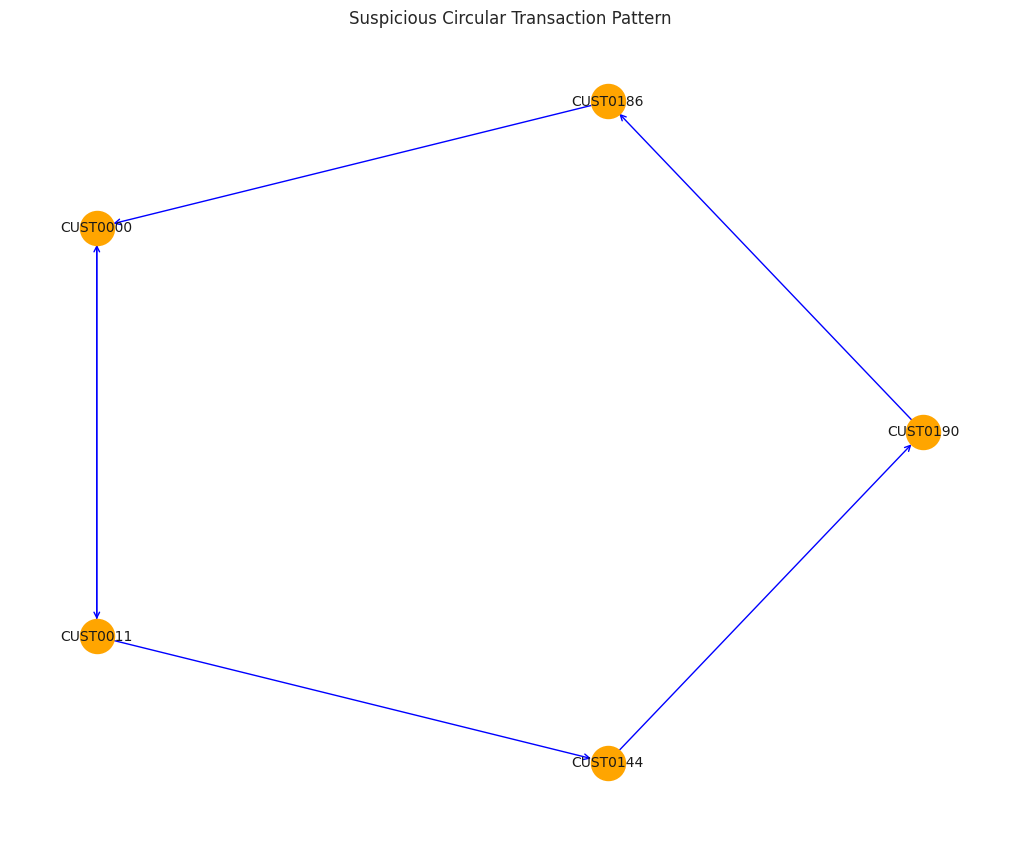

In [33]:
# Visualize circular transaction pattern
if len(loop_cycles) > 0:
    best_cycle = max(loop_cycles, key=lambda c: len(set(c).intersection(set(suspicious_ids))))
    cycle_graph = network_graph.subgraph(best_cycle)

    plt.figure(figsize=(10, 8))
    pos = nx.circular_layout(cycle_graph)
    nx.draw(cycle_graph, pos, with_labels=True, node_color='orange', edge_color='blue',
            node_size=600, font_size=10, arrows=True, arrowstyle='->')
    plt.title("Suspicious Circular Transaction Pattern")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("circular_transactions.png", dpi=300)
    plt.show()


This visual shows:
- A circular flow involving 5 accounts.
- At least 2 of these nodes are flagged as suspicious.
- The layout is circular to reflect the cyclical nature of the transactions.
- Circular transactions are classic signs of money laundering or fund obfuscation, where money is passed in loops to hide its source. The presence of flagged accounts here strengthens suspicion of collusion or coordinated activity.

Visualize community structure

In [34]:
def visualize_communities(G, partition, suspicious_ids, max_communities=5, figsize=(18, 12)):

    # Step 1: Get the largest communities
    community_sizes = Counter(partition.values())
    top_communities = [c for c, _ in community_sizes.most_common(max_communities)]

    # Step 2: Include only nodes in these communities
    selected_nodes = [n for n in G.nodes() if partition.get(n) in top_communities]
    subgraph = G.subgraph(selected_nodes)

    # Step 3: Generate positions
    pos = nx.spring_layout(subgraph, seed=42, iterations=100)

    plt.figure(figsize=figsize)

    # Step 4: Assign distinct colors to communities
    color_map = plt.get_cmap("tab10")
    community_colors = {comm: color_map(i % 10) for i, comm in enumerate(top_communities)}

    # Step 5: Draw each community
    for comm in top_communities:
        community_nodes = [n for n in subgraph.nodes() if partition[n] == comm]
        nx.draw_networkx_nodes(
            subgraph, pos, nodelist=community_nodes,
            node_color=community_colors[comm],
            node_size=300, alpha=0.6,
            label=f"Community {comm}"
        )

    # Step 6: Draw suspicious nodes on top in red
    suspicious_in_graph = [n for n in subgraph.nodes() if n in suspicious_ids]
    nx.draw_networkx_nodes(
        subgraph, pos,
        nodelist=suspicious_in_graph,
        node_color='red', node_size=600, alpha=1.0
    )

    # Step 7: Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2, arrows=True, arrowstyle='->')

    # Step 8: Label only suspicious nodes
    labels = {n: n for n in suspicious_in_graph}
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=9)

    # Step 9: Final touch
    plt.title("Community Structure with Suspicious Accounts Highlighted", fontsize=16)
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.tight_layout()
    plt.savefig('community_structure.png', dpi=300)
    plt.show()


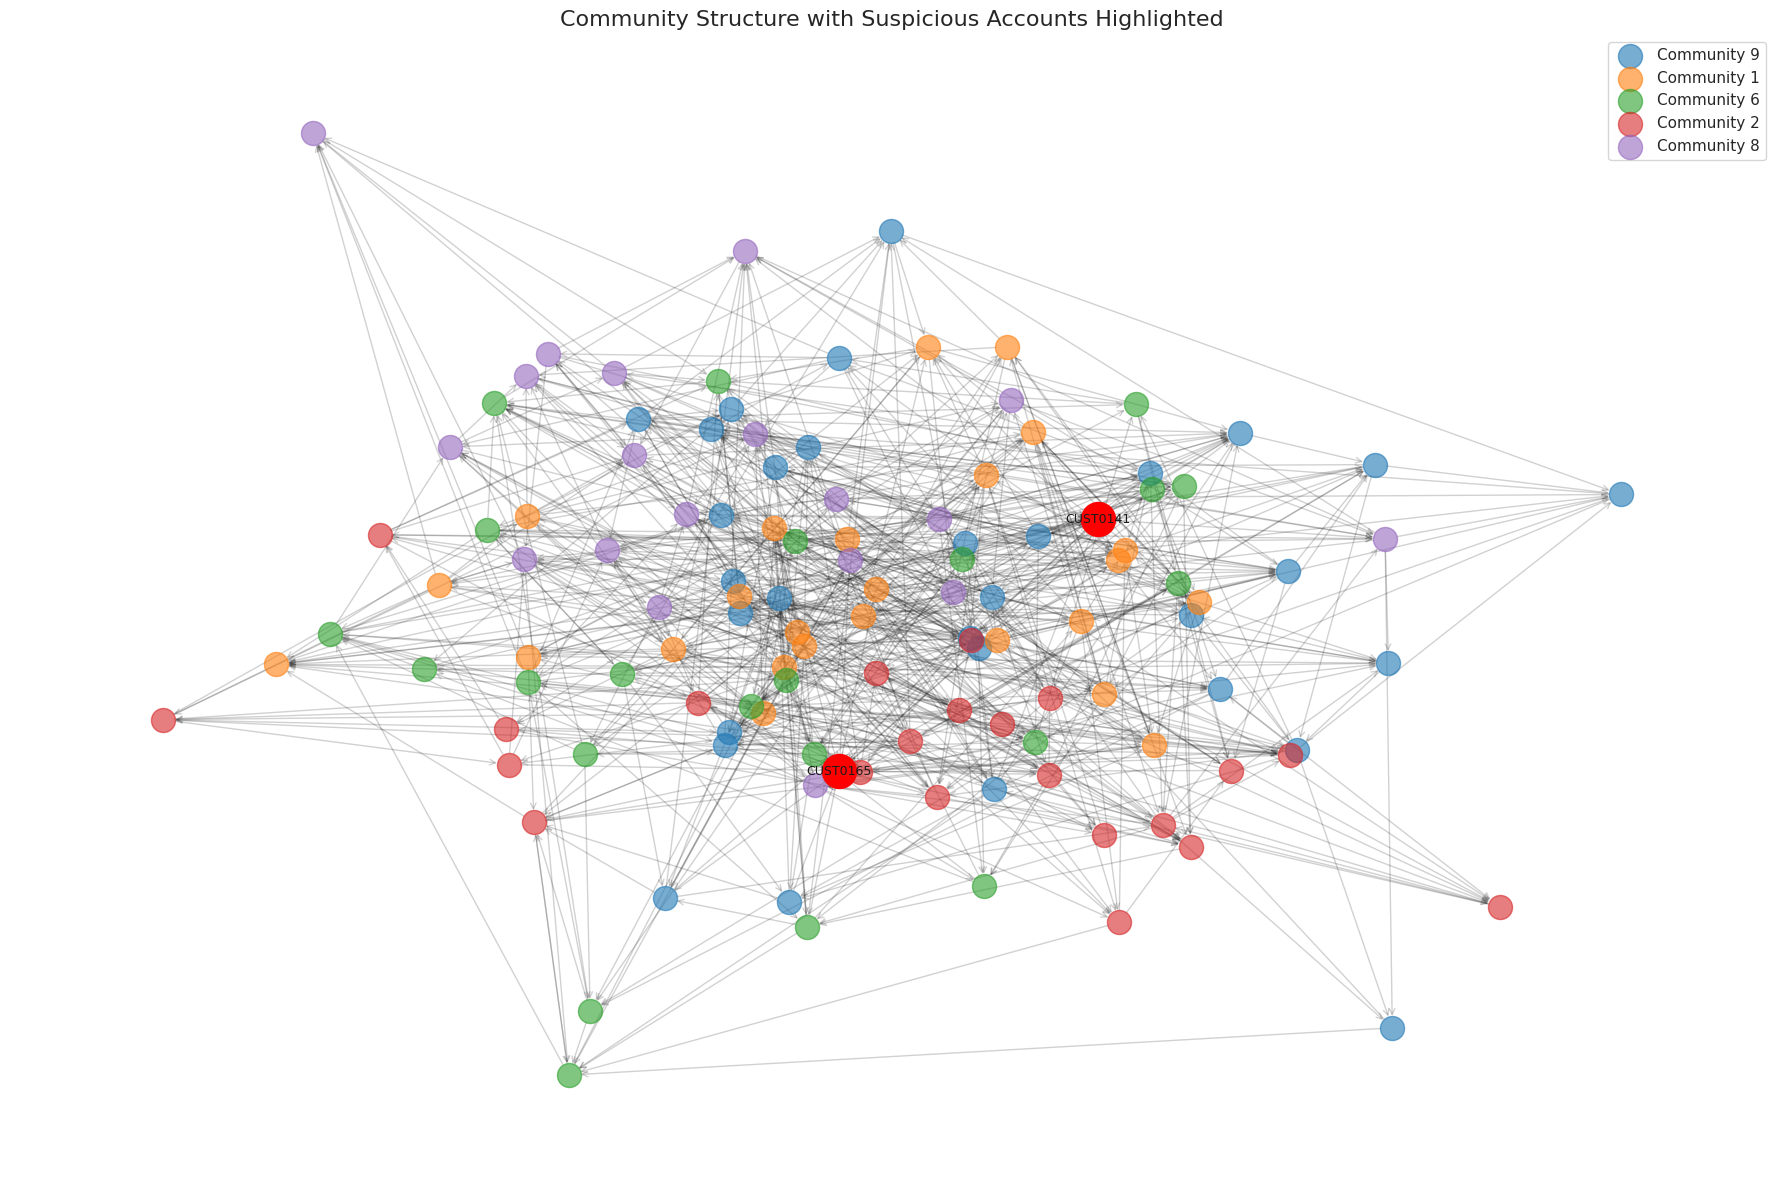

In [35]:
# Call visualize_communities func
visualize_communities(network_graph, partition, suspicious_ids)


This visual shows:
- The full network grouped by community clusters (color-coded).
- The suspicious accounts are highlighted in red.
- Some red nodes appear deeply embedded in communities, others at edges or bridges.

By mapping flagged accounts onto natural transaction clusters, we identify:
- Suspicious actors embedded in tight-knit groups (possible collusion)
- Bridge accounts crossing communities. It gives context on where and how risk is spreading in the network.

# Conclusion

In [39]:
print("## Final Summary & Insights\n")

# Summary statistics
print(f" Total customers analyzed: {network_graph.number_of_nodes()}")
print(f" Total transactions processed: {network_graph.number_of_edges()}")
print(f" Suspicious accounts flagged: {len(final_flags)}")
print(f" Circular transaction loops detected: {len(loop_cycles)}")

# Risk segment distribution
print("\n Distribution of Suspicious Accounts by Risk Segment:")
display(final_flags['risk_segment'].value_counts())

# Frequent red flag reasons
print("\n Most Common Reasons for Flagging:")
reason_list = []
for reason_text in final_flags['flag_reason']:
    reason_list.extend(reason_text.split(" | "))
display(pd.Series(reason_list).value_counts())

# Detailed view of flagged accounts
print("\n Flagged Accounts with Reasons:")
display(final_flags[['customer_id', 'name', 'risk_segment', 'total_anomaly_flags', 'flag_reason']])

# Final written narrative
print("\n Conclusion:")
print("""
This network-based fraud detection analysis for Upesi Digital Bank identified
5 suspicious accounts based on structural, flow, and temporal patterns:

1. Sleeper accounts — inactive for long periods but burst into activity suddenly.
2. Circular transactions — detected 1500 loops, some involving flagged users.
3. Bridge accounts — accounts linking different communities, possibly laundering facilitators.
4. High-volume intermediaries — pass-through behavior within short time gaps and balanced flows.

 Visualizations offered critical context:
- Flagged nodes in red revealed their roles in clusters, loops, and high-betweenness paths.
- Community structure helped reveal potential collusion rings.
- Circular layout exposed obfuscation loops.

 Recommendations:
- Enable real-time network-based monitoring and anomaly scoring.
- Trigger alerts for high bridge scores, bursty activity, and cycles.
- Combine network flags with metadata like nationality, account type, and historical behavior.
- Pass these findings to the compliance unit for deeper forensic review.

 Files Generated:
- Flagged accounts: `'flagged_customers.csv'`
- Graph visuals: `'suspicious_cluster.png'`, `'circular_transactions.png'`, `'community_structure.png'`
""")


## Final Summary & Insights

 Total customers analyzed: 200
 Total transactions processed: 1953
 Suspicious accounts flagged: 5
 Circular transaction loops detected: 1500

 Distribution of Suspicious Accounts by Risk Segment:


,count
risk_segment,
low,3
high,1
medium,1



 Most Common Reasons for Flagging:


,count
High network influence,5
Unusual network position,4
Likely pass-through or money mule,3
Sleeper account behavior,2



 Flagged Accounts with Reasons:


,customer_id,name,risk_segment,total_anomaly_flags,flag_reason
11,CUST0011,Customer_11,high,3,High network influence | Sleeper account behavior
84,CUST0084,Customer_84,low,3,Unusual network position | High network influe...
141,CUST0141,Customer_141,low,3,Unusual network position | High network influence
144,CUST0144,Customer_144,low,4,Unusual network position | High network influe...
165,CUST0165,Customer_165,medium,5,Unusual network position | High network influe...



 Conclusion:

This network-based fraud detection analysis for Upesi Digital Bank identified 
5 suspicious accounts based on structural, flow, and temporal patterns:

1. Sleeper accounts — inactive for long periods but burst into activity suddenly.
2. Circular transactions — detected 1500 loops, some involving flagged users.
3. Bridge accounts — accounts linking different communities, possibly laundering facilitators.
4. High-volume intermediaries — pass-through behavior within short time gaps and balanced flows.

 Visualizations offered critical context:
- Flagged nodes in red revealed their roles in clusters, loops, and high-betweenness paths.
- Community structure helped reveal potential collusion rings.
- Circular layout exposed obfuscation loops.

 Recommendations:
- Enable real-time network-based monitoring and anomaly scoring.
- Trigger alerts for high bridge scores, bursty activity, and cycles.
- Combine network flags with metadata like nationality, account type, and historical